In [2]:
%cd /Users/gduval/Documents/TOSICA

import TOSICA
import scanpy as sc
import numpy as np
import warnings 
warnings.filterwarnings ("ignore")

/Users/gduval/Documents/TOSICA


Information of GPU

In [3]:
import torch
from sklearn.model_selection import train_test_split
print(torch.__version__)
#print(torch.cuda.get_device_capability(device=None),  torch.cuda.get_device_name(device=None))

2.4.0


Reference data

In [3]:
ref_adata = sc.read('../data/ref_sbm/mATLAS_Marrow_facs.h5ad')
ref_adata = ref_adata[:,ref_adata.var_names]
#print(ref_adata)
#print(ref_adata.obs['free_annotation'].value_counts())

train_data = sc.read('data/demo_train.h5ad')
test_data = sc.read('data/demo_test.h5ad')
print(train_data)
print(test_data)

AnnData object with n_obs × n_vars = 10600 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
AnnData object with n_obs × n_vars = 4218 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'


Alternative data loading method

In [ ]:
# Load the reference and query datasets
all_data = sc.read("../input/matlas-facs/mATLAS_Marrow_facs.h5ad")

# Select most variable genes maybe ?
sc.pp.highly_variable_genes(all_data, n_top_genes=8000)
all_data = all_data[:, all_data.var["highly_variable"]]

# Keep only a small subset of the data
#fraction = 0.4
#sampled_idx = np.random.choice(all_data.n_obs, 
                               #int(all_data.n_obs * fraction), 
                               #replace=False)
#print(len(sampled_idx))
#subset_data = all_data[sampled_idx, :].copy() 

# Split into train and test
train_idx, test_idx = train_test_split(
np.arange(all_data.n_obs), test_size=0.2, random_state=42
) 
adata = all_data[train_idx, :].copy()
adata_test = all_data[test_idx, :].copy()

# Keep only common genes between both datasets - only useful for an outside
# dataset 
#common_genes = adata.var_names.intersection(adata_test.var_names)
#adata = adata[:, common_genes]
#adata_test = adata_test[:, common_genes]

# Set the cell type as the label and add batch id
adata.obs["celltype"] = adata.obs["cell_ontology_class"].astype(str).astype("category")
adata_test.obs["celltype"] = adata_test.obs["cell_ontology_class"].astype(str).astype("category")

# Add gene names as features 
# The gene names need to be capitalised for human to mouse conversion
# if this is happening
adata.var['gene_name'] = adata.var['n_cells'].index
adata_test.var['gene_name'] = adata_test.var['n_cells'].index

# Set these as index
adata.var.set_index(adata.var["gene_name"], inplace=True)
adata_test.var.set_index(adata_test.var["gene_name"], inplace=True)
                
# make the batch category column
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))

# Delete useless copies
del all_data

Query data

In [ ]:
query_adata = sc.read('../data/raw_sbm/raw_sbm_data_2024_11_15.h5ad')
query_adata = query_adata[:,query_adata.var_names]
print(query_adata)

View of AnnData object with n_obs × n_vars = 22454 × 32285
    obs: '0'
    var: '0'


Training:

In [ ]:
TOSICA.train(ref_adata, gmt_path='mouse_gobp', label_name='free_annotation',epochs=1,project='results/mSBM_test')
!ls ./hGOBP_demo

cpu
Mask loaded!
Model builded!


[train epoch 0] loss: 3.142, acc: 0.028:   0%|          | 18/3618 [01:50<6:09:53,  6.16s/it]


KeyboardInterrupt: 

### Prediction (start from here if using pre-trained model)

In [4]:
# Load the reference and query datasets
test = sc.read("../data/raw_sbm/manual_annot.h5ad")

# In theory, should keep only common genes with training dataset - this was not done during training, but have to be revisited


# Here we shall only keep the top 8000 highly variables genes
sc.pp.highly_variable_genes(test, n_top_genes=8000)
test = test[:, test.var["highly_variable"]]

# Add some pre-processing columns
test.obs["celltype"] = test.obs["cluster_annot"].astype(str).astype("category")
test.var['gene_name'] = test.var['features'].index
test.var.set_index(test.var["features"], inplace=True)

print(test)

AnnData object with n_obs × n_vars = 24807 × 8000
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'mitoPercent', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.2.5', 'seurat_clusters', 'old.ident', 'cluster_annot', 'celltype'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [6]:
model_weight_path = 'results/mATLAS_droplet/8000heg_32bs_mATLAS_droplet.pth'
new_adata = TOSICA.pre(test, model_weight_path = model_weight_path,project='results/mATLAS_droplet')

cpu
0
10000
20000
24807


In [ ]:
new_adata.obs = new_adata.obs.applymap(str)
new_adata.var = new_adata.var.applymap(str)
new_adata.write('results/mATLAS_droplet/annot.h5ad')
new_adata

AnnData object with n_obs × n_vars = 24807 × 299
    obs: 'Prediction', 'Probability', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'mitoPercent', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.2.5', 'seurat_clusters', 'old.ident', 'cluster_annot', 'celltype'

In [9]:
new_adata.raw = new_adata
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)
sc.pp.scale(new_adata, max_value=10)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


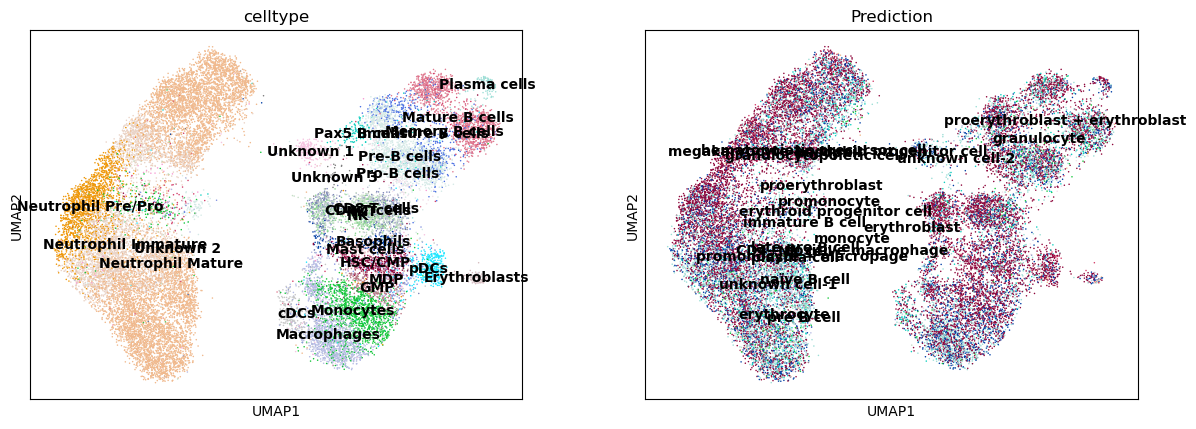

In [11]:
sc.pl.umap(new_adata, color=['celltype', 'Prediction'],legend_loc='on data')

Training on pre-weights of 'human_gobp' mask:

In [11]:
!cp ./hGOBP_demo/model-0.pth ./pre_weights.pth

In [12]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',pre_weights='pre_weights.pth',epochs=1)

cuda:0
Mask loaded!
<All keys matched successfully>
Model builded!


[valid epoch 0] loss: 0.040, acc: 0.992: 100%|██████████| 5096/5096 [00:31<00:00, 162.61it/s]


Training finished!
